In [1]:
import os
import PyImbalReg as pir
import pandas as pd
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import resreg
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("/home/usr/Documents/reg-class-fault-detection/dataset/kpi_fuller_df.csv")

In [3]:
def label_func(faultD):
  if(faultD == 0): return 0
  elif(faultD < 500): return 1
  else: return 2

In [4]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def reg_acc(md, data, test_labels):
  test_predictions = md.predict(data).flatten()
  r2 = r2_score(test_labels, test_predictions)
  rmse = np.sqrt(mean_squared_error(test_labels, test_predictions))
  mae = mean_absolute_error(test_labels, test_predictions)

  print(f'r2 score: {r2}')
  print(f'rmse score: {rmse}')
  print(f'mae score: {mae}')
  # print(f'erro medio de: {rmse} segundos')

  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([0,plt.xlim()[1]])
  plt.ylim([0,plt.ylim()[1]])
  _ = plt.plot([-100, 100], [-100, 100])

In [5]:
df = df.sample(frac=1)
test_data = df[:(len(df)//5)]
train_data = df[(len(df)//5):]

X_test = test_data.drop(columns=['Unnamed: 0','NE ID','endTime', 'relation','fault_duration']).values
y_test_fd = test_data.fault_duration.values
y_test = test_data.fault_duration.apply(label_func).values

train_data['fault'] = train_data['fault_duration'].apply(label_func)

train_data = train_data.dropna()
train_data = train_data.drop(columns=['Unnamed: 0','NE ID','endTime','relation'])

/tmp/ipykernel_37706/1550130980.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['fault'] = train_data['fault_duration'].apply(label_func)


In [6]:
y = train_data.fault_duration.values
X = train_data.drop(columns=['fault','fault_duration']).values

faults = train_data[train_data['fault_duration'] > 0]
X_fault = faults.drop(columns=['fault','fault_duration']).values
y_fault = faults.fault_duration.values

In [7]:
X_test = test_data.drop(columns=['Unnamed: 0','NE ID','endTime', 'relation','fault_duration']).values
y_test_fd = test_data.fault_duration.values
y_test = test_data.fault_duration.apply(label_func).values


In [8]:
def custom_relevance(y, cl, ch):
    sig = resreg.sigmoid_relevance(y, cl, ch)
    return np.array([s - 1 for s in sig])

In [9]:
def relevance_deviation(y, cl, ch):
    mean = (cl + ch)/2
    arr = []
    for sample in y:
        arr.append(1 - (abs(sample - mean)/mean))

    return arr

In [41]:
def relevance_line(y, value):
    return [1 - 0.00026*s for s in y]

/home/usr/anaconda3/envs/cnn-env/lib/python3.11/site-packages/resreg/resreg.py:39: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-s * (y - c)))


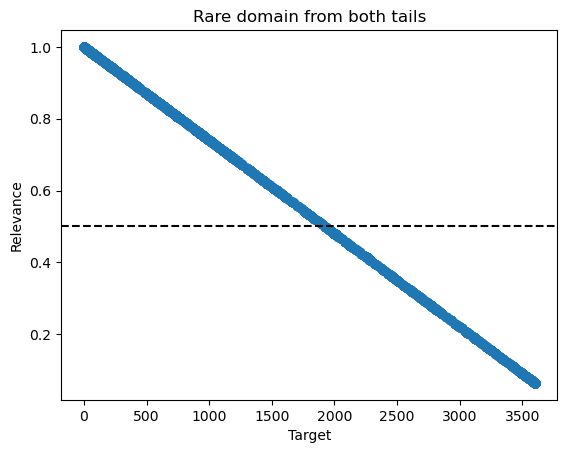

In [42]:
low_y = 0 # Rare domain boundary for left tail
high_y = 3600 # Rare domain boundary for right tail

relevance_both = resreg.sigmoid_relevance(y, cl=low_y, ch=high_y)
relevance_both_custom = custom_relevance(y, cl=low_y, ch=high_y)
relevance_right = resreg.sigmoid_relevance(y, cl=None, ch=high_y)
relevance_step =  (y > low_y)^(y >= high_y) 
# relevance_dev = relevance_deviation(y, cl=low_y, ch=high_y)

relevance_dev = relevance_line(y,0.75)

plt.scatter(y, relevance_dev)
plt.axhline(0.5, linestyle='--', color='black')
plt.ylabel('Relevance')
plt.xlabel('Target')
plt.title('Rare domain from both tails')
plt.show()
plt.close()



In [13]:
def implementML(X_train, y_train, X_test, y_test, reg):
    reg.fit(X_train, y_train) # fit regressor
    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rel_test = custom_relevance(y_test, cl=low_y, ch=high_y) # relevance values of y_test
    rel_pred = custom_relevance(y_pred, cl=low_y, ch=high_y) # relevance values of y_pred
    f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=rel_test,
                        relevance_pred=rel_pred, relevance_threshold=0.5)
    # msebin = resreg.bin_performance(y_test, y_pred, bins=bins, metric='mse')
    msebin = 0
    return (r2, f1, msebin)

In [14]:
# Save performance results
CACHE = {}

# Function to plot performance results
ticks_font = {'size':'12'}
label_font = {'size':'14'}
title_font = {'size':'16'}

bins = [500]


def plotPerformance(msebin, msebinerr, f1, r2, title):
    plt.bar(range(2), msebin, yerr=msebinerr, width=0.4, capsize=3, color='royalblue',
           linewidth=1, edgecolor='black')
    plt.xlim(-0.5, len(bins)+0.5)
    plt.xticks(range(2), ['< {0}'.format(bins[0]), '≥ {0}'.format(bins[0])], **ticks_font)
    plt.yticks(**ticks_font)
    plt.ylabel('Mean Squared Error (MSE)', **label_font)
    plt.xlabel('Target value range', **label_font)
    title = title + '\nf1={0}, r2={1}'.format(round(f1,3), round(r2,3))
    plt.title(title, **title_font)
    plt.show()
    plt.close()


In [23]:
# # Parameters
# overs = [0.5, 0.75, 1.0] # percent of samples added
# unders = [0.5, 0.75] # percent of samples removed
# noises = [True, False] # Whether to add Gaussian noise to oversampled data
# deltas = [0.01, 0.1, 0.5] # amount of Gaussian noise
# params = list(itertools.product(overs, unders, [noises[1]])) + \
#             list(itertools.product(overs, unders, [noises[0]], deltas))

# # Empty lists for storing results
# r2store, f1store, msebinstore = [], [], []
# r2errstore, f1errstore, msebinerrstore = [], [], []
# i = 0
# # Grid search
# for param in params:
#     if len(param)==4:
#         over, under, noise, delta = param
#     else:
#         over, under, noise = param
#         delta = None
#     kfold = KFold(n_splits=5, shuffle=True, random_state=0)
#     r2s, f1s, msebins = [], [], [] 
    
#     # Fivefold cross validation
#     for train_index, test_index in kfold.split(X):
#         X_train, y_train = X[train_index,:], y[train_index]
#         X_test, y_test = X[test_index,:], y[test_index]
        
#         # Resample training data (WERCS)
#         relevance = custom_relevance(y_train, cl=low_y, ch=high_y)
#         X_train, y_train = resreg.wercs(X_train, y_train, relevance, over=over,
#                               under=under, noise=noise, delta=delta, random_state=0)
        
#         # Fit regressor and evaluate performance
#         reg = RandomForestRegressor(n_estimators=50, max_features=0.5, n_jobs=-1, 
#                                     random_state=0)
#         r2, f1, msebin = implementML(X_train, y_train, X_test, y_test, reg)
#         r2s.append(r2)
#         f1s.append(f1)
#         msebins.append(msebin)
#     r2, f1, msebin = np.mean(r2s), np.mean(f1), np.mean(msebins, axis=0)
#     r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
#                                 np.std(msebins, axis=0)/np.sqrt(5)
    
#     # Store grid search results
#     print(f"r2 score  {i} iteração")
#     r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
#     r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)
#     i += 1


# # Determine the best parameters
# best = np.argsort(f1store)[-1] # Which is the best
# bestparam = params[best]
# if len(param)==4:
#     over, under, noise, delta= param
# else:
#     over, under, noise = param
#     delta = None
# print(f'''Best parameters:
#     over={over}; under={under}; noise={noise}; delta={delta}''')
# f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
# f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# # Save results
# CACHE['WERCS'] = [r2, f1, msebin, r2err, f1err, msebinerr] 

# # Plot results
# plotPerformance(msebin, msebinerr, f1, r2, title='WERCS')

In [30]:
CACHE

{'WERCS': [-15.522378444902808,
  4.3913135898141025e-05,
  0.0,
  0.12380712677910621,
  1.0165345330943442e-05,
  0.0]}

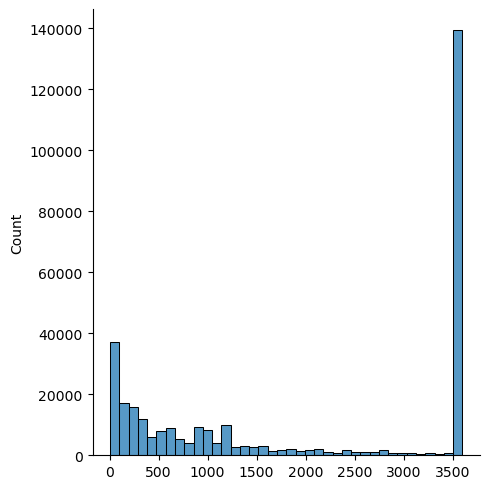

In [46]:
relevance_faults = relevance_line(y_fault, 0.7)
X_train, y_train = resreg.wercs(X_fault, y_fault, relevance_faults , over=10, under=0.9999, random_state=0)

sns.displot(y_train)

In [47]:
test_faults = test_data[test_data['fault_duration'] > 0]
X_test_faults = test_faults.drop(columns=['Unnamed: 0','NE ID','endTime', 'relation','fault_duration']).values
y_test_fd_faults = test_faults.fault_duration.values

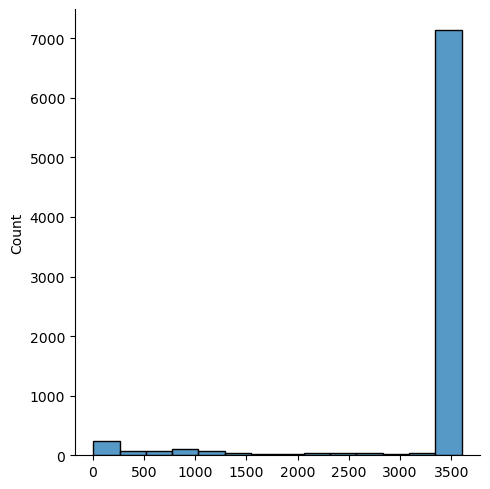

In [48]:
sns.displot(y_test_fd_faults)

r2 score: -0.9919154917031139
rmse score: 1152.2874237073556
mae score: 1032.4568182384453


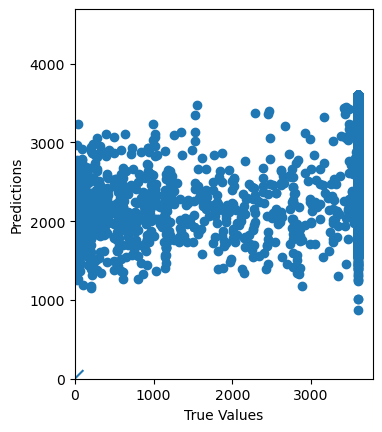

In [72]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=50, max_features=0.5, n_jobs=-1, 
                                    random_state=0)
reg.fit(X_train, y_train)

reg_acc(reg, X_test_faults,y_test_fd_faults )

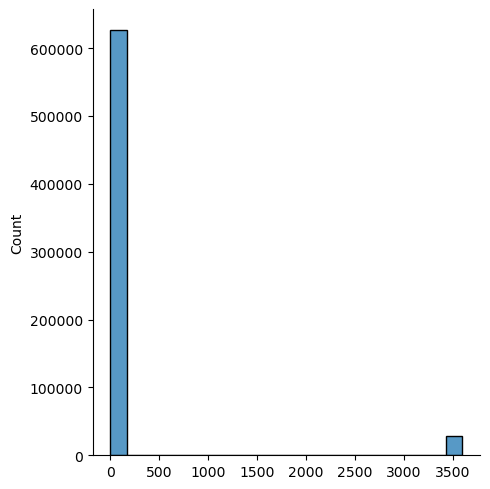

In [35]:
sns.displot(y)

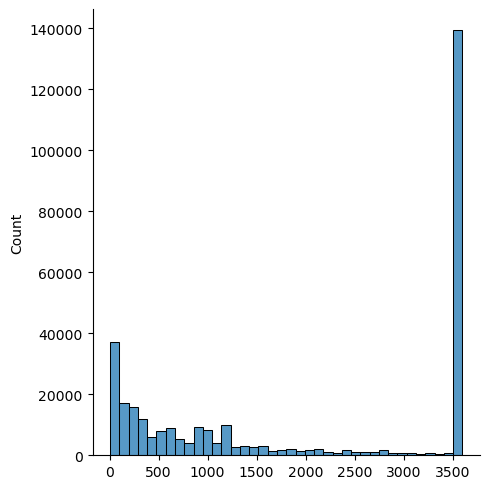

In [49]:
sns.displot(y_train)